# Imports

---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


# Make Model

---



In [3]:
def make_model():
    base_model = ResNet50(include_top=False, input_shape=(150, 150, 3), weights=None)
    base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x) 
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x) 
    x = Dropout(0.3)(x)
    predictions = Dense(6, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [4]:
make_model().summary()

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                 

# Setting up Input Data Generators

---



In [5]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.savefig('acc_vs_epochs.png')

In [6]:
train_path = '../input/intelsceneclassification/data/data/train'

In [7]:
valid_path = '../input/intelsceneclassification/data/data/valid'

No data augmentation for now.

In [8]:
train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=20,
      horizontal_flip=True,
      vertical_flip=False
)

In [9]:
valid_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=20,
      horizontal_flip=True,
      vertical_flip=False
)

In [10]:
train_generator = train_datagen.flow_from_directory(train_path, target_size=(150, 150), batch_size=32, shuffle=True, seed=42)

Found 13627 images belonging to 6 classes.


In [11]:
valid_generator = valid_datagen.flow_from_directory(valid_path, target_size=(150, 150), batch_size=32, shuffle=True, seed=42)

Found 3407 images belonging to 6 classes.


# Training

---

In [12]:
model = make_model()

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [13]:
model.compile(Adam(lr=0.0001, decay=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
filepath="VGG16" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=3)
callbacks_list = [checkpoint]

In [15]:
history = model.fit_generator(train_generator, 
                              epochs = 20, 
                              steps_per_epoch = 13627 // 32,
                              shuffle = True, 
                              validation_data = valid_generator,
                              validation_steps = 3407 // 32,
                              callbacks = callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
425/425 [==============================] - 134s 314ms/step - loss: 0.6312 - acc: 0.8091 - val_loss: 0.3866 - val_acc: 0.8662

Epoch 00001: saving model to VGG16_model_weights.h5
Epoch 2/20
425/425 [==============================] - 102s 241ms/step - loss: 0.3653 - acc: 0.8734 - val_loss: 0.2649 - val_acc: 0.9153

Epoch 00002: saving model to VGG16_model_weights.h5
Epoch 3/20
425/425 [==============================] - 104s 245ms/step - loss: 0.3222 - acc: 0.8909 - val_loss: 0.3505 - val_acc: 0.8776

Epoch 00003: saving model to VGG16_model_weights.h5
Epoch 4/20
425/425 [==============================] - 103s 242ms/step - loss: 0.2655 - acc: 0.9080 - val_loss: 0.2682 - val_acc: 0.9016

Epoch 00004: saving model to VGG16_model_weights.h5
Epoch 5/20
425/425 [==============================] - 105s 246ms/step - loss: 0.2454 - acc: 0.9160 - val_loss: 0.3030 - val_acc: 0.8981

Epoch 00005: saving model to VGG16_model_weights.h5
Epoch 6

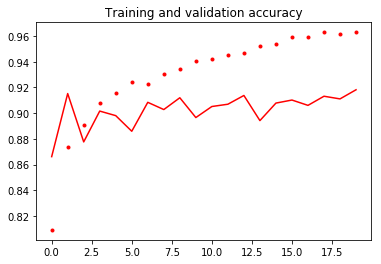

In [16]:
plot_training(history)

In [17]:
import os

In [18]:
test_path = '../input/intelsceneclassification/data/data/test'

In [19]:
results = []

In [20]:
for image_name in os.listdir(test_path):
    image_path = test_path + '/' + image_name
    image = load_img(image_path, target_size=(150, 150))
    image = img_to_array(image)
    image = np.array(image)
    image = preprocess_input(image)
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    prediction = np.argmax(model.predict(image))
    results.append({'image_name': image_name, 'label':prediction})

In [21]:
df = pd.DataFrame(results, columns=['image_name', 'label'])

In [22]:
df['label'].value_counts()

3    1378
5    1252
2    1229
1    1173
4    1142
0    1127
Name: label, dtype: int64

In [23]:
df.to_csv("resnet_med_20epochs_higherlr_higherdecay.csv", index=False)

In [24]:
ls

VGG16_model_weights.h5  acc_vs_epochs.png
__notebook__.ipynb      resnet_med_20epochs_higherlr_higherdecay.csv
__output__.json
